In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [39]:
df=pd.read_csv('song_data.csv')
df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [44]:
df.drop_duplicates(inplace=True)

In [22]:
df.drop(['song_name'], axis=1, inplace=True)

target = 'song_popularity'
features = [i for i in df.columns if i not in [target]]

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:
        cf.append(nu.index[i])
    else: 
        nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100


df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape


Inference: The Datset has 10 numerical & 3 categorical features.
One-Hot Encoding on features:
audio_mode

Dummy Encoding on features:
time_signature
key


(18835, 27)

In [23]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,73,262333,0.005520,0.496,0.682,0.000029,0.0589,-4.095,True,0.0294,...,False,False,False,False,False,False,True,False,False,False
1,66,216933,0.010300,0.542,0.853,0.000000,0.1080,-6.407,False,0.0498,...,False,True,False,False,False,False,False,False,False,False
2,74,216933,0.026400,0.451,0.970,0.003550,0.1020,-4.938,True,0.1070,...,False,False,False,False,False,False,False,False,False,False
3,56,223826,0.000954,0.447,0.766,0.000000,0.1130,-5.065,True,0.0313,...,False,False,False,False,False,False,False,False,True,False
4,80,235893,0.008950,0.316,0.945,0.000002,0.3960,-3.169,False,0.1240,...,False,False,True,False,False,False,False,False,False,False



Inference:
Before removal of outliers, The dataset had 18835 samples.
After removal of outliers, The dataset now has 11307 samples.


In [24]:
m=[]
for i in df3.columns.values:
    m.append(i.replace(' ','_'))
    
df3.columns = m
X = df3.drop([target],axis=1)
Y = df3[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (18835, 26) (18835,) 
Training set  --->  (15068, 26) (15068,) 
Testing set   --->  (3767, 26)  (3767,)


In [25]:
std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,...,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04,1.506800e+04
mean,7.250195e-17,-6.931894e-17,3.640423e-16,-7.521341e-16,-4.385484e-17,-1.537277e-16,-1.277921e-16,-1.886230e-18,-8.157944e-17,-4.800455e-16,...,-9.431149e-19,-4.338328e-17,-5.941624e-17,-1.320361e-17,3.772459e-18,4.338328e-17,-1.355728e-17,-3.159435e-17,1.414672e-17,-5.187132e-18
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,...,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00
min,-3.402136e+00,-8.932474e-01,-4.052709e+00,-3.009608e+00,-3.490036e-01,-1.169465e+00,-7.645949e+00,-1.297139e+00,-9.800930e-01,-4.225288e+00,...,-3.156156e-01,-1.657721e-01,-2.743852e-01,-3.039062e-01,-2.782806e-01,-3.486376e-01,-2.795245e-01,-3.165047e-01,-2.763378e-01,-3.059861e-01
25%,-5.559920e-01,-8.092002e-01,-6.329982e-01,-6.257980e-01,-3.490036e-01,-5.996105e-01,-4.105900e-01,-1.297139e+00,-6.170481e-01,-7.776522e-01,...,-3.156156e-01,-1.657721e-01,-2.743852e-01,-3.039062e-01,-2.782806e-01,-3.486376e-01,-2.795245e-01,-3.165047e-01,-2.763378e-01,-3.059861e-01
50%,-1.141271e-01,-4.401380e-01,7.651189e-02,1.361911e-01,-3.489536e-01,-4.052630e-01,2.343260e-01,7.709271e-01,-4.456370e-01,-4.083306e-02,...,-3.156156e-01,-1.657721e-01,-2.743852e-01,-3.039062e-01,-2.782806e-01,-3.486376e-01,-2.795245e-01,-3.165047e-01,-2.763378e-01,-3.059861e-01
75%,4.033323e-01,5.698542e-01,7.284942e-01,7.953350e-01,-3.376501e-01,2.818940e-01,6.607879e-01,7.709271e-01,1.754876e-01,6.539379e-01,...,-3.156156e-01,-1.657721e-01,-2.743852e-01,-3.039062e-01,-2.782806e-01,-3.486376e-01,-2.795245e-01,-3.165047e-01,-2.763378e-01,-3.059861e-01
max,2.607772e+01,2.551791e+00,2.256178e+00,1.655494e+00,4.142416e+00,5.598685e+00,2.359846e+00,7.709271e-01,8.081585e+00,4.223325e+00,...,3.168411e+00,6.032377e+00,3.644512e+00,3.290489e+00,3.593495e+00,2.868308e+00,3.577504e+00,3.159511e+00,3.618759e+00,3.268122e+00



                                          Standardardization on Testing set                                          


,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,...,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000
mean,-0.004772,0.005019,-0.021795,0.002990,0.026301,0.009138,0.005017,0.009470,0.015525,-0.019873,...,0.008093,0.013574,0.008583,-0.017652,-0.002826,-0.007899,-0.016382,-0.015687,-0.005429,-0.011860
std,0.937201,0.993187,1.008627,1.004359,1.030980,0.996918,0.998225,0.997593,1.025392,1.005595,...,1.011579,1.039104,1.014458,0.973252,0.995432,0.990098,0.972602,0.977451,0.991003,0.982336
min,-2.700513,-0.893246,-3.653210,-3.002269,-0.349004,-1.142395,-8.178439,-1.297139,-0.759570,-2.553368,...,-0.315616,-0.165772,-0.274385,-0.303906,-0.278281,-0.348638,-0.279524,-0.316505,-0.276338,-0.305986
25%,-0.574242,-0.811621,-0.677742,-0.646835,-0.349004,-0.602387,-0.437619,-1.297139,-0.614159,-0.812605,...,-0.315616,-0.165772,-0.274385,-0.303906,-0.278281,-0.348638,-0.279524,-0.316505,-0.276338,-0.305986
50%,-0.118811,-0.415926,0.025376,0.136191,-0.348948,-0.391381,0.233543,0.770927,-0.442748,-0.041844,...,-0.315616,-0.165772,-0.274385,-0.303906,-0.278281,-0.348638,-0.279524,-0.316505,-0.276338,-0.305986
75%,0.408656,0.594066,0.722102,0.795335,-0.335629,0.316599,0.678807,0.770927,0.165858,0.625731,...,-0.315616,-0.165772,-0.274385,-0.303906,-0.278281,-0.348638,-0.279524,-0.316505,-0.276338,-0.305986
max,10.698104,2.551791,2.153906,1.646145,4.178747,5.515393,2.083024,0.770927,7.831209,3.143845,...,3.168411,6.032377,3.644512,3.290489,3.593495,2.868308,3.577504,3.159511,3.618759,3.268122


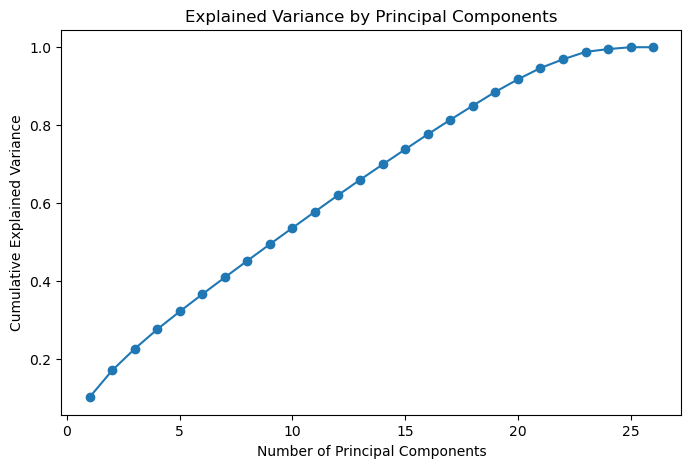

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
PC1,1.009242e-02,-4.280627e-01,1.816654e-01,4.710989e-01,-2.245373e-02,8.099672e-02,4.045470e-01,-9.740660e-02,1.855903e-01,6.796609e-02,...,-2.285521e-02,-4.640006e-02,-3.550733e-02,-1.546760e-02,3.376151e-02,-2.860112e-02,9.791086e-03,-1.437004e-02,-2.332896e-02,5.038972e-02
PC2,-9.616399e-02,2.564502e-01,2.029908e-01,-3.359384e-01,-1.515223e-02,-1.207638e-01,-3.490691e-01,2.382972e-02,-7.972656e-02,-1.852736e-01,...,-3.780802e-03,-1.621466e-02,-5.009618e-03,6.388081e-02,-1.569662e-02,1.352851e-02,-4.381969e-02,1.388893e-02,2.299923e-02,-2.201023e-02
PC3,-2.351873e-01,7.403672e-02,5.547763e-01,-1.168136e-01,-1.631295e-01,-1.535584e-01,-3.252641e-02,-2.816733e-01,3.598498e-01,-1.766023e-01,...,-2.226221e-01,-3.486032e-02,-1.631120e-02,1.029546e-02,2.757545e-02,-1.434960e-01,-1.758785e-03,-4.961995e-02,1.039916e-01,1.382408e-01
PC4,-3.040940e-01,5.295248e-02,1.422540e-01,7.426433e-02,-1.281263e-01,-6.013003e-02,6.363702e-02,5.390968e-01,-6.711853e-02,-3.866729e-02,...,3.095452e-01,-1.329531e-02,-1.891898e-01,-1.053777e-01,-2.628599e-01,2.208063e-01,1.991048e-01,-4.982513e-02,-1.519720e-01,-2.808933e-01
PC5,2.128641e-01,-8.458968e-02,-6.868863e-02,-1.249680e-01,1.292891e-03,-1.853718e-01,-1.431422e-02,1.400418e-01,2.631269e-01,-8.311904e-03,...,1.034007e-01,-6.524548e-02,-2.279597e-01,-2.130720e-01,1.586308e-01,-1.047799e-01,1.420447e-01,-2.586673e-01,2.850917e-02,-1.469181e-01
PC6,-1.397270e-01,3.322861e-02,-4.947837e-02,-6.238693e-02,-2.892791e-01,3.689729e-01,-2.137917e-02,4.425950e-03,1.551041e-01,1.060700e-01,...,2.818504e-02,-1.809993e-01,2.810581e-01,-1.651012e-01,-1.801003e-01,4.152907e-01,-3.314367e-01,-4.031375e-01,1.064104e-01,1.907617e-01
PC7,9.863711e-02,-2.883590e-02,9.627123e-02,-1.142159e-02,2.746481e-01,-6.314020e-02,-5.481246e-02,1.535993e-02,1.084492e-01,2.290082e-02,...,-4.350839e-01,3.082344e-02,-1.754981e-01,-2.562755e-01,1.536838e-01,5.653436e-01,3.838338e-01,-1.199349e-01,1.069854e-01,-8.172899e-03
PC8,-7.414026e-02,-1.148389e-02,-5.452536e-02,-1.990053e-02,2.661969e-02,-4.570179e-02,-5.892679e-02,-1.728762e-02,2.813610e-02,2.153722e-01,...,-2.162225e-01,-1.096995e-02,-1.450062e-02,-4.079561e-01,-1.046838e-01,1.455541e-01,-3.139133e-01,6.765994e-01,4.169761e-02,-1.473969e-01
PC9,1.206177e-01,-4.912679e-02,9.070541e-04,1.067723e-02,-2.151183e-02,-2.017676e-02,4.449832e-02,-2.333090e-02,-1.066222e-01,-6.876219e-02,...,-3.526894e-01,-1.376761e-02,-7.578748e-02,6.227789e-01,2.559340e-02,3.234815e-01,-2.574305e-01,-6.764617e-02,-2.507859e-01,-3.557098e-01
PC10,-1.254285e-02,2.664053e-02,-2.080729e-02,6.758189e-03,1.132999e-03,7.151299e-02,2.506981e-02,5.391926e-03,2.577007e-02,1.245789e-01,...,-2.313653e-01,-4.332480e-02,5.306013e-01,5.024916e-02,-2.204236e-01,-2.530040e-01,3.746926e-01,-4.976140e-02,2.983096e-01,-4.892160e-01


In [26]:
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df1.drop(columns=['song_popularity']))

# Apply PCA
pca = PCA().fit(Train_X_std)
pca_result = pca.fit_transform(normalized_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Determine feature importance
loadings = pd.DataFrame(pca.components_, columns=df1.columns[1:], index=[f'PC{i+1}' for i in range(len(pca.components_))])
loadings

In [27]:
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [1.03015663e-01 6.85277552e-02 5.54558161e-02 4.99775495e-02
 4.58072954e-02 4.41149905e-02 4.32989158e-02 4.26690578e-02
 4.23639900e-02 4.17893614e-02 4.16527887e-02 4.13574803e-02
 4.03078635e-02 3.92042344e-02 3.88033913e-02 3.84672459e-02
 3.72180546e-02 3.62386184e-02 3.54402093e-02 3.20283684e-02
 2.90365456e-02 2.22572130e-02 1.89904367e-02 7.22218679e-03
 4.75496824e-03 5.45029264e-18]


As the result shown, the first five principal components capture approximately 54.22% of the total variance in the data 

## <u>What PCA can tell us</u>
* What is the vector that represents a particular combination of travel rating preferences that describes the highest amount of variability in the dataset?
* What is the vector that represents a particular combination of travel rating preferences that describes the second highest amount of variability in the dataset?
* The third highest amount of data variability?
* How many vectors do we need to describe *most* of the total variance of the original 10 attributes?
* How important is each of these new attribute vectors to a given object in the dataset?


In [28]:
correlations = df1.corr()
print(correlations['song_popularity'].sort_values(ascending=False))

song_popularity     1.000000
loudness            0.127018
danceability        0.109311
key_1               0.052602
speechiness         0.040417
key_6               0.036989
song_duration_ms    0.024676
time_signature_4    0.023297
key_11              0.016618
key_10              0.006717
key_8               0.004803
key_5               0.004479
energy              0.003831
time_signature_5   -0.000330
time_signature_1   -0.004630
audio_mode         -0.006988
key_4              -0.010849
tempo              -0.022604
key_3              -0.024621
time_signature_3   -0.025122
liveness           -0.028290
key_9              -0.032930
key_2              -0.033089
key_7              -0.040603
instrumentalness   -0.042959
acousticness       -0.086781
audio_valence      -0.088746
Name: song_popularity, dtype: float64


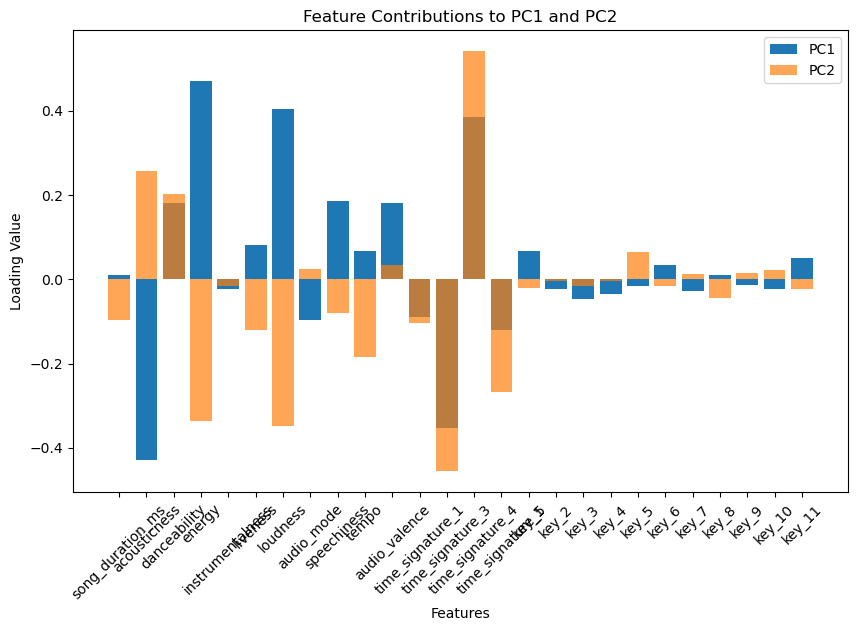

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(loadings.columns, loadings.loc['PC1'], label='PC1')
plt.bar(loadings.columns, loadings.loc['PC2'], label='PC2', alpha=0.7)
plt.xticks(rotation=45)
plt.title('Feature Contributions to PC1 and PC2')
plt.xlabel('Features')
plt.ylabel('Loading Value')
plt.legend()
plt.show()


In [30]:
# Use retained PCs as predictors
retained_pcs = pca_result  
reg = LinearRegression()
reg.fit(retained_pcs, df1['song_popularity'])

print("Regression coefficients for PCs:", reg.coef_)


Regression coefficients for PCs: [ 1.04968990e+00 -2.95532975e-01  1.16133505e+00 -7.28809179e-01
  2.00610413e+00  3.05216257e-02 -2.00473358e-01 -6.10404724e-01
  4.67204516e-01  7.58273844e-02 -1.18959347e-01 -1.40295308e-01
 -6.58582311e-01 -1.73448840e-01 -9.32905068e-01 -2.33076934e-01
 -1.10877397e+00 -3.07533988e-01  7.71732238e-02 -1.27307760e+00
  1.15695473e+00  3.31884402e+00  2.74835023e+00 -3.22324782e+00
 -5.32430957e-01  6.17930234e-16]


In [31]:
df1

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,audio_mode,speechiness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,73,262333,0.005520,0.496,0.682,0.000029,0.0589,-4.095,True,0.0294,...,False,False,False,False,False,False,True,False,False,False
1,66,216933,0.010300,0.542,0.853,0.000000,0.1080,-6.407,False,0.0498,...,False,True,False,False,False,False,False,False,False,False
2,74,216933,0.026400,0.451,0.970,0.003550,0.1020,-4.938,True,0.1070,...,False,False,False,False,False,False,False,False,False,False
3,56,223826,0.000954,0.447,0.766,0.000000,0.1130,-5.065,True,0.0313,...,False,False,False,False,False,False,False,False,True,False
4,80,235893,0.008950,0.316,0.945,0.000002,0.3960,-3.169,False,0.1240,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11302,55,114582,0.898000,0.370,0.136,0.000263,0.0999,-13.528,True,0.0433,...,False,False,False,False,False,True,False,False,False,False
11303,64,216173,0.862000,0.515,0.286,0.000069,0.1060,-11.776,True,0.0378,...,False,False,False,True,False,False,False,False,False,False
11304,62,195106,0.395000,0.644,0.523,0.000000,0.0930,-7.660,True,0.0378,...,False,False,True,False,False,False,False,False,False,False
11305,23,182211,0.847000,0.719,0.325,0.000000,0.1250,-12.222,True,0.0355,...,False,False,False,False,False,False,False,False,False,False


In [32]:
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (11307, 26) (11307,) 
Training set  --->  (9045, 26) (9045,) 
Testing set   --->  (2262, 26)  (2262,)


In [33]:
# Random Forest model
model = RandomForestClassifier()
model.fit(Train_X, Train_Y)

accuracy = model.score(Test_X, Test_Y)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.3421750663129973


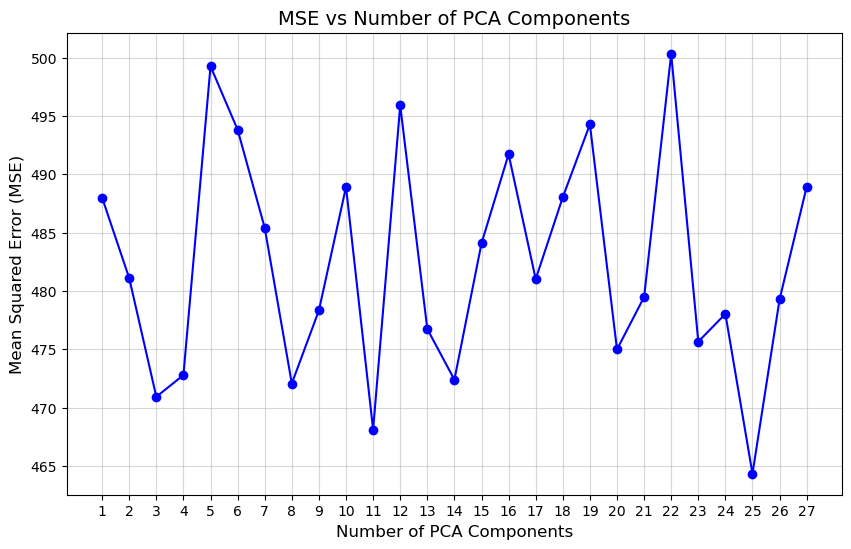

In [38]:
mse_values = []

target = df['song_popularity']
for i in range(27):
    pca = PCA(n_components=i)  
    pca_result = pca.fit_transform(normalized_data)

    model = RandomForestClassifier()
    model.fit(Train_X, Train_Y)
    scaler = StandardScaler()
    
    
    y_pred = model.predict(Test_X)
    mse = mean_squared_error(Test_Y, y_pred)
    
    # accuracy = model.score(X_test, y_test)
    mse_values.append(mse)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 28), mse_values, marker='o', linestyle='-', color='b')
plt.title('MSE vs Number of PCA Components', fontsize=14)
plt.xlabel('Number of PCA Components', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.xticks(range(1, 28))
plt.grid(alpha=0.5)
plt.show()